In [1]:
import pandas as pd
import torch, torchvision
import json
import cv2
import numpy as np
from copy import deepcopy
import matplotlib.pyplot as plt
import glob2
import pickle as pkl
import os
from PIL import Image
import re
from transformers import BertTokenizer, VisualBertModel
from transformers import CLIPProcessor, CLIPModel
from torchvision.models import vgg16
import torch.nn as nn
import PIL
from torchvision import transforms
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
import seaborn as sns
import pylab
import matplotlib
from matplotlib.lines import Line2D

Get visual embedding for VisualBERT

In [2]:
from detectron2.modeling import build_model
from detectron2.checkpoint import DetectionCheckpointer
from detectron2.structures.image_list import ImageList
from detectron2.data import transforms as T
from detectron2.modeling.box_regression import Box2BoxTransform
# from detectron2.modeling.roi_heads.fast_rcnn import FastRCNNOutputLayers
from detectron2.structures.boxes import Boxes
from detectron2.layers import nms
from detectron2 import model_zoo
from detectron2.config import get_cfg
import torch.nn.functional as F

In [ ]:
device=torch.device('cuda:1')
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
cfg_path = "COCO-InstanceSegmentation/mask_rcnn_R_101_FPN_3x.yaml"
df=pd.read_csv("priority_memes.csv")
image_files=glob2.glob('/mnt/sda/dataset/google_insta_reddit/batch1/postprocessing/with_text/*')
image_files.extend(glob2.glob("/mnt/sda/dataset/google_insta_reddit/batch2/postprocessing/with_text/*"))

model = VisualBertModel.from_pretrained('uclanlp/visualbert-nlvr2-coco-pre')
tokenizer = BertTokenizer.from_pretrained('bert-large-uncased')
model = model.to(device)
vgg = vgg16(pretrained=True)
vgg.classifier=nn.Sequential(*list(vgg.classifier.children())[:-1])

In [3]:
# load detectron model
def load_config_and_model_weights(cfg_path):
    cfg = get_cfg()
    cfg.merge_from_file(model_zoo.get_config_file(cfg_path))

    # ROI HEADS SCORE THRESHOLD
    cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5

    # Comment the next line if you're using 'cuda'
#     cfg['MODEL']['DEVICE']='cuda'

    cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url(cfg_path)

    return cfg

cfg = load_config_and_model_weights(cfg_path)

In [4]:
def get_model(cfg):
    # build model
    model = build_model(cfg)

    # load weights
    checkpointer = DetectionCheckpointer(model)
    checkpointer.load(cfg.MODEL.WEIGHTS)

    # eval mode
    model.eval()
    return model

model = get_model(cfg).to(device)

In [5]:
def prepare_image_inputs(cfg, img_list):
    # Resizing the image according to the configuration
    transform_gen = T.ResizeShortestEdge(
                [cfg.INPUT.MIN_SIZE_TEST, cfg.INPUT.MIN_SIZE_TEST], cfg.INPUT.MAX_SIZE_TEST
            )
    img_list = [transform_gen.get_transform(img).apply_image(img) for img in img_list]

    # Convert to C,H,W format
    convert_to_tensor = lambda x: torch.Tensor(x.astype("float32").transpose(2, 0, 1)).to(device)

    batched_inputs = [{"image":convert_to_tensor(img), "height": img.shape[0], "width": img.shape[1]} for img in img_list]

    # Normalizing the image
    num_channels = len(cfg.MODEL.PIXEL_MEAN)
    pixel_mean = torch.Tensor(cfg.MODEL.PIXEL_MEAN).view(num_channels, 1, 1).to(device)
    pixel_std = torch.Tensor(cfg.MODEL.PIXEL_STD).view(num_channels, 1, 1).to(device)
    normalizer = lambda x: (x - pixel_mean) / pixel_std
    images = [normalizer(x["image"]) for x in batched_inputs]

    # Convert to ImageList
    images =  ImageList.from_tensors(images,model.backbone.size_divisibility)
    
    return images, batched_inputs

In [6]:
def get_features(model, images):
    features = model.backbone(images.tensor)
    return features

In [7]:
def get_proposals(model, images, features):
    proposals, _ = model.proposal_generator(images, features)
    return proposals

In [8]:
def get_box_features(model, features, proposals):
    features_list = [features[f] for f in ['p2', 'p3', 'p4', 'p5']]
    box_features = model.roi_heads.box_pooler(features_list, [x.proposal_boxes for x in proposals])
    box_features = model.roi_heads.box_head.flatten(box_features)
    box_features = model.roi_heads.box_head.fc1(box_features)
    box_features = model.roi_heads.box_head.fc_relu1(box_features)
    box_features = model.roi_heads.box_head.fc2(box_features)

    box_features = box_features.reshape(1, 1000, 1024) # depends on your config and batch size
    return box_features, features_list

In [9]:
def get_prediction_logits(model, features_list, proposals):
    cls_features = model.roi_heads.box_pooler(features_list, [x.proposal_boxes for x in proposals])
    cls_features = model.roi_heads.box_head(cls_features)
    pred_class_logits, pred_proposal_deltas = model.roi_heads.box_predictor(cls_features)
    return pred_class_logits, pred_proposal_deltas

In [10]:
class FastRCNNOutputs:
     """
     An internal implementation that stores information about outputs of a Fast R-CNN head,
     and provides methods that are used to decode the outputs of a Fast R-CNN head.
     """

    def __init__(
     self,
     box2box_transform,
     pred_class_logits,
     pred_proposal_deltas,
     proposals,
     smooth_l1_beta=0.0,
     box_reg_loss_type="smooth_l1",
    ):
     """
     Args:
         box2box_transform (Box2BoxTransform/Box2BoxTransformRotated):
             box2box transform instance for proposal-to-detection transformations.
         pred_class_logits (Tensor): A tensor of shape (R, K + 1) storing the predicted class
             logits for all R predicted object instances.
             Each row corresponds to a predicted object instance.
         pred_proposal_deltas (Tensor): A tensor of shape (R, K * B) or (R, B) for
             class-specific or class-agnostic regression. It stores the predicted deltas that
             transform proposals into final box detections.
             B is the box dimension (4 or 5).
             When B is 4, each row is [dx, dy, dw, dh (, ....)].
             When B is 5, each row is [dx, dy, dw, dh, da (, ....)].
         proposals (list[Instances]): A list of N Instances, where Instances i stores the
             proposals for image i, in the field "proposal_boxes".
             When training, each Instances must have ground-truth labels
             stored in the field "gt_classes" and "gt_boxes".
             The total number of all instances must be equal to R.
         smooth_l1_beta (float): The transition point between L1 and L2 loss in
             the smooth L1 loss function. When set to 0, the loss becomes L1. When
             set to +inf, the loss becomes constant 0.
         box_reg_loss_type (str): Box regression loss type. One of: "smooth_l1", "giou"
     """
         self.box2box_transform = box2box_transform
         self.num_preds_per_image = [len(p) for p in proposals]
         self.pred_class_logits = pred_class_logits
         self.pred_proposal_deltas = pred_proposal_deltas
         self.smooth_l1_beta = smooth_l1_beta
         self.box_reg_loss_type = box_reg_loss_type

         self.image_shapes = [x.image_size for x in proposals]

         if len(proposals):
             box_type = type(proposals[0].proposal_boxes)
             # cat(..., dim=0) concatenates over all images in the batch
             self.proposals = box_type.cat([p.proposal_boxes for p in proposals])
             assert (
                 not self.proposals.tensor.requires_grad
             ), "Proposals should not require gradients!"

             # "gt_classes" exists if and only if training. But other gt fields may
             # not necessarily exist in training for images that have no groundtruth.
             if proposals[0].has("gt_classes"):
                 self.gt_classes = cat([p.gt_classes for p in proposals], dim=0)

                 # If "gt_boxes" does not exist, the proposals must be all negative and
                 # should not be included in regression loss computation.
                 # Here we just use proposal_boxes as an arbitrary placeholder because its
                 # value won't be used in self.box_reg_loss().
                 gt_boxes = [
                     p.gt_boxes if p.has("gt_boxes") else p.proposal_boxes for p in proposals
                 ]
                 self.gt_boxes = box_type.cat(gt_boxes)
         else:
             self.proposals = Boxes(torch.zeros(0, 4, device=self.pred_proposal_deltas.device))
         self._no_instances = len(self.proposals) == 0  # no instances found

    def softmax_cross_entropy_loss(self):
         """
         Deprecated
         """
         _log_classification_stats(self.pred_class_logits, self.gt_classes)
         return cross_entropy(self.pred_class_logits, self.gt_classes, reduction="mean")

    def box_reg_loss(self):
         """
         Deprecated
         """
         if self._no_instances:
             return 0.0 * self.pred_proposal_deltas.sum()

         box_dim = self.proposals.tensor.size(1)  # 4 or 5
         cls_agnostic_bbox_reg = self.pred_proposal_deltas.size(1) == box_dim
         device = self.pred_proposal_deltas.device

         bg_class_ind = self.pred_class_logits.shape[1] - 1
         # Box delta loss is only computed between the prediction for the gt class k
         # (if 0 <= k < bg_class_ind) and the target; there is no loss defined on predictions
         # for non-gt classes and background.
         # Empty fg_inds should produce a valid loss of zero because reduction=sum.
         fg_inds = nonzero_tuple((self.gt_classes >= 0) & (self.gt_classes < bg_class_ind))[0]

         if cls_agnostic_bbox_reg:
             # pred_proposal_deltas only corresponds to foreground class for agnostic
             gt_class_cols = torch.arange(box_dim, device=device)
         else:
             # pred_proposal_deltas for class k are located in columns [b * k : b * k + b],
             # where b is the dimension of box representation (4 or 5)
             # Note that compared to Detectron1,
             # we do not perform bounding box regression for background classes.
             gt_class_cols = box_dim * self.gt_classes[fg_inds, None] + torch.arange(
                 box_dim, device=device
             )

         if self.box_reg_loss_type == "smooth_l1":
             gt_proposal_deltas = self.box2box_transform.get_deltas(
                 self.proposals.tensor, self.gt_boxes.tensor
             )
             loss_box_reg = smooth_l1_loss(
                 self.pred_proposal_deltas[fg_inds[:, None], gt_class_cols],
                 gt_proposal_deltas[fg_inds],
                 self.smooth_l1_beta,
                 reduction="sum",
             )
         elif self.box_reg_loss_type == "giou":
             fg_pred_boxes = self.box2box_transform.apply_deltas(
                 self.pred_proposal_deltas[fg_inds[:, None], gt_class_cols],
                 self.proposals.tensor[fg_inds],
             )
             loss_box_reg = giou_loss(
                 fg_pred_boxes,
                 self.gt_boxes.tensor[fg_inds],
                 reduction="sum",
             )
         else:
             raise ValueError(f"Invalid bbox reg loss type '{self.box_reg_loss_type}'")

         loss_box_reg = loss_box_reg / self.gt_classes.numel()
         return loss_box_reg

    def losses(self):
         """
         Deprecated
         """
         return {"loss_cls": self.softmax_cross_entropy_loss(), "loss_box_reg": self.box_reg_loss()}

    def predict_boxes(self):
         """
         Deprecated
         """
         pred = self.box2box_transform.apply_deltas(self.pred_proposal_deltas, self.proposals.tensor)
         return pred.split(self.num_preds_per_image, dim=0)

    def predict_probs(self):
         """
         Deprecated
         """
         probs = F.softmax(self.pred_class_logits, dim=-1)
         return probs.split(self.num_preds_per_image, dim=0)

In [11]:
def get_box_scores(cfg, pred_class_logits, pred_proposal_deltas):
    box2box_transform = Box2BoxTransform(weights=cfg.MODEL.ROI_BOX_HEAD.BBOX_REG_WEIGHTS)
    smooth_l1_beta = cfg.MODEL.ROI_BOX_HEAD.SMOOTH_L1_BETA

        
    outputs = FastRCNNOutputs(
        box2box_transform,
        pred_class_logits,
        pred_proposal_deltas,
        proposals,
        smooth_l1_beta
    )

    boxes = outputs.predict_boxes()
    scores = outputs.predict_probs()
    image_shapes = outputs.image_shapes
    return boxes, scores, image_shapes

In [12]:
def get_output_boxes(boxes, batched_inputs, image_size):
    proposal_boxes = boxes.reshape(-1, 4).clone()
    scale_x, scale_y = (batched_inputs["width"] / image_size[1], batched_inputs["height"] / image_size[0])
    output_boxes = Boxes(proposal_boxes)

    output_boxes.scale(scale_x, scale_y)
    output_boxes.clip(image_size)

    return output_boxes

In [13]:
def select_boxes(cfg, output_boxes, scores):
    test_score_thresh = cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST
    test_nms_thresh = cfg.MODEL.ROI_HEADS.NMS_THRESH_TEST
    cls_prob = scores.detach()
    cls_boxes = output_boxes.tensor.detach().reshape(1000,80,4)
    max_conf = torch.zeros((cls_boxes.shape[0])).to(device)
    for cls_ind in range(0, cls_prob.shape[1]-1):
        cls_scores = cls_prob[:, cls_ind+1]
        det_boxes = cls_boxes[:,cls_ind,:]
        keep = np.array(nms(det_boxes, cls_scores, test_nms_thresh).cpu())
        max_conf[keep] = torch.where(cls_scores[keep] > max_conf[keep], cls_scores[keep], max_conf[keep])
    keep_boxes = torch.where(max_conf >= test_score_thresh)[0]
    return keep_boxes, max_conf

In [14]:
MIN_BOXES=2
MAX_BOXES=10
def filter_boxes(keep_boxes, max_conf, min_boxes, max_boxes):
    if len(keep_boxes) < min_boxes:
        keep_boxes = np.argsort(max_conf.cpu()).numpy()[::-1][:min_boxes]
    elif len(keep_boxes) > max_boxes:
        keep_boxes = np.argsort(max_conf.cpu()).numpy()[::-1][:max_boxes]
    return keep_boxes

In [15]:
def get_visual_embeds(box_features, keep_boxes):
    return box_features[keep_boxes.copy()]

In [4]:
data=[]
image_file_names=[file.split("/")[-1] for file in image_files]
for i,row in df.iterrows():
    data.append((row["text"].replace("\n"," "),\
                image_files[image_file_names.index(row['filename'])]))

In [20]:
# write vl bert embeddings
failed=[]
for text,img in data:  
    try:    
        img1 = plt.imread(img)
        # # Detectron expects BGR images
        img_bgr = cv2.cvtColor(img1, cv2.COLOR_RGB2BGR)
        images, batched_inputs = prepare_image_inputs(cfg, [img_bgr])
        features = get_features(model, images)
        proposals = get_proposals(model, images, features)
        box_features, features_list = get_box_features(model, features, proposals)
        pred_class_logits, pred_proposal_deltas = get_prediction_logits(model, features_list, proposals)
        boxes, scores, image_shapes = get_box_scores(cfg, pred_class_logits, pred_proposal_deltas)
        output_boxes = [get_output_boxes(boxes[i], batched_inputs[i], proposals[i].image_size) \
                        for i in range(len(proposals))]
        temp = [select_boxes(cfg, output_boxes[i], scores[i]) for i in range(len(scores))]
        keep_boxes, max_conf = [],[]
        for keep_box, mx_conf in temp:
            keep_boxes.append(keep_box)
            max_conf.append(mx_conf)
        keep_boxes = [filter_boxes(keep_box, mx_conf, MIN_BOXES, MAX_BOXES) \
                      for keep_box, mx_conf in zip(keep_boxes, max_conf)]
        visual_embeds = [get_visual_embeds(box_feature, keep_box) \
                         for box_feature, keep_box in zip(box_features, keep_boxes)]
        visual_embeds = torch.stack(visual_embeds)
        text = re.sub(r"(?:\@|https?\://)\S+", "", text.lower())

        inputs = tokenizer(text, return_tensors="pt")
        inputs={'input_ids':inputs['input_ids'].to(device),'token_type_ids':inputs['token_type_ids'].to(device)}
        visual_attention_mask = torch.ones(visual_embeds.shape[:-1], dtype=torch.long).to(device)
        visual_token_type_ids = torch.ones(visual_embeds.shape[:-1], dtype=torch.long).to(device)

        inputs.update({
                 "visual_embeds": visual_embeds,
                 "visual_token_type_ids": visual_token_type_ids,
                 "visual_attention_mask": visual_attention_mask,
             })
        embeddings = model(**inputs).last_hidden_state.cpu()[:,0,:]
        with open('vlBERT_embeddings/{}.pkl'.format(img.split("/")[-1]),'wb') as f:
            pkl.dump(embeddings,f)
    except:
        failed.append(img)

In [29]:
#  # this checkpoint has 1024 dimensional visual embeddings projection
model = BertModel.from_pretrained("bert-large-uncased")
model=model.to(device)

Some weights of the model checkpoint at bert-large-uncased were not used when initializing BertModel: ['cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


CLIP embedding

In [28]:
model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32")
processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")
model = model.to(Device)
for text,image in data: 
    img = Image.open(image)
    text = re.sub(r"(?:\@|https?\://)\S+", "", text.lower())
    inputs = processor(text=[text], images=img, return_tensors="pt", padding=True)
    inputs_trimmed={
        'input_ids':inputs['input_ids'][:,:77],
        'attention_mask':inputs['attention_mask'][:,:77],
        'pixel_values':inputs['pixel_values']
    }

    outputs = model(**inputs_trimmed)
    with open('clip_embeddings/{}'.format(image.split("/")[-1]),'wb') as f:
        pkl.dump(outputs,f)

Token indices sequence length is longer than the specified maximum sequence length for this model (83 > 77). Running this sequence through the model will result in indexing errors


BERT embedding

In [32]:
model = BertModel.from_pretrained("bert-large-uncased").to(device)
model = model.to(Device)
for text,image in data: 
    img = Image.open(image)
    text = re.sub(r"(?:\@|https?\://)\S+", "", text.lower())
    inputs = tokenizer(text, return_tensors="pt")
    
    outputs = model(**inputs)['last_hidden_state'][:,0,:].cpu()
    with open('bert_embeddings/{}'.format(image.split("/")[-1]),'wb') as f:
        pkl.dump(outputs,f)

VGG embedding

In [26]:
transform=transforms.Compose([
            transforms.Resize((224,224)),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
            ])
for text,image in data:
    img=PIL.Image.open(image).convert('RGB')
    img=transform(img)
    encoding=vgg(img.unsqueeze(0)).view(-1,512)
    with open("vgg_embeddings/{}".format(image.split("/")[-1]),"wb") as f:
        pkl.dump(encoding,f)

Kmeans on CLIP embeddings

In [12]:
num_clusters=10
device='cuda:1'
x=[]
files=[]
labels_clip=[]
for file in os.listdir("clip_embeddings"):
    if(file.replace(".pkl","") in list(single_pillar_memes.keys())):
        files.append(file)
        labels_clip.append(single_pillar_memes[file.replace(".pkl","")])
        
        with open(os.path.join("clip_embeddings",file),'rb') as f:
            encoding=pkl.load(f)
        encoding=torch.cat((encoding['text_embeds'],encoding['image_embeds']),1)    
        x.append(encoding.view(1,-1))
       
x_clip=torch.cat(x,0).to(device)
kmeans_clip = KMeans(n_clusters=7, random_state=0, n_init=10).fit(np.array(x_clip.tolist()))

Comparing clusters with labels

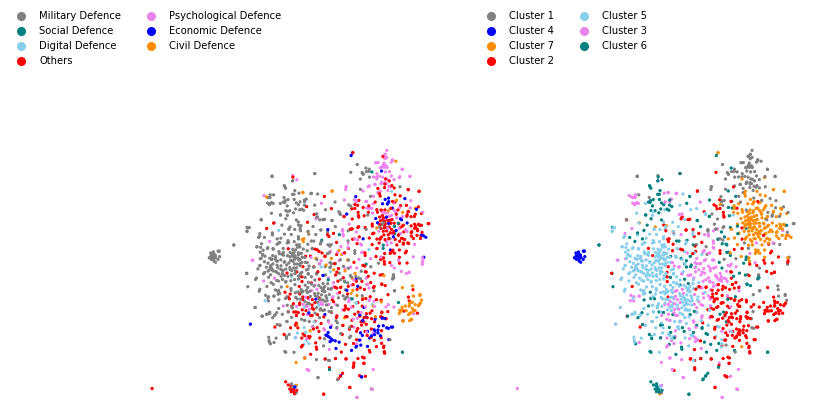

In [27]:
X_embedded_clip = TSNE(n_components=2, learning_rate=100,
                   init='random', perplexity=20).fit_transform(x_clip.tolist())


fig,(ax1,ax2) = plt.subplots(ncols=2,figsize=(12, 5))
colors=['gray', 'darkorange', 'blue', 'teal', 'violet','skyblue','red']

t1,t2  = X_embedded_vlbert[:,0],X_embedded_vlbert[:,1]
t3,t4  = X_embedded_clip[:,0],X_embedded_clip[:,1]

labels_dict={'Military Defence':0,'Civil Defence':1,'Economic Defence':2,'Social Defence':3,\
             'Psychological Defence':4,'Digital Defence':5,'Others':6}
labels_int=[labels_dict[lbl] for lbl in labels_vlbert]
labels_int2=[labels_dict[lbl] for lbl in labels_clip]

ax1.scatter(t3, t4,s=5, c=labels_int2, cmap=matplotlib.colors.ListedColormap(colors))

ax2.scatter(t3, t4,s=5, c=kmeans_clip.labels_, cmap=matplotlib.colors.ListedColormap(colors))

legend_elements = [Line2D([0], [0], marker='o', color=colors[0], label='Military Defence',
                           markersize=8,linestyle='none'),
                   
                   
                   
                   Line2D([0], [0], marker='o', color=colors[3], label='Social Defence',
                           markersize=8,linestyle='none'),
                   
                   Line2D([0], [0], marker='o', color=colors[5], label='Digital Defence',
                           markersize=8,linestyle='none'),
                   
                   Line2D([0], [0], marker='o', color=colors[6], label='Others',
                           markersize=8,linestyle='none'),
                   
                   
                   
                   Line2D([0], [0], marker='o', color=colors[4], label='Psychological Defence',
                           markersize=8,linestyle='none'),
                   
                   
                   
                   Line2D([0], [0], marker='o', color=colors[2], label='Economic Defence',
                           markersize=8,linestyle='none'), 
                   
                   Line2D([0], [0], marker='o', color=colors[1], label='Civil Defence',
                           markersize=8,linestyle='none')
                   
                   ]

legend_elements2 = [Line2D([0], [0], marker='o', color=colors[0], label='Cluster 1',
                           markersize=8,linestyle='none'),
                   Line2D([0], [0], marker='o', color=colors[2], label='Cluster 4',
                           markersize=8,linestyle='none'),  
                   Line2D([0], [0], marker='o', color=colors[1], label='Cluster 7',
                           markersize=8,linestyle='none'),
                   
                   Line2D([0], [0], marker='o', color=colors[6], label='Cluster 2',
                           markersize=8,linestyle='none'),
                   Line2D([0], [0], marker='o', color=colors[5], label='Cluster 5',
                           markersize=8,linestyle='none'),
                   Line2D([0], [0], marker='o', color=colors[4], label='Cluster 3',
                           markersize=8,linestyle='none'),
                   Line2D([0], [0], marker='o', color=colors[3], label='Cluster 6',
                           markersize=8,linestyle='none')                   
                   
                   ]

ax1.legend(handles=legend_elements, loc='upper right',fontsize=10,bbox_to_anchor=(0.5, 1.5),\
         ncol=2,frameon=False)
ax2.legend(handles=legend_elements2, loc='upper right',fontsize=10,bbox_to_anchor=(0.5, 1.5),\
         ncol=2,frameon=False)
ax1.axis('off')
ax2.axis('off')
plt.show()